# Single neuron dynamics

# note: run this example with Python3 kernel

## libs and path

In [1]:
fileName = 'eg_single-cell' 

In [2]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


../outputs/eg_single-cell-2024-04-22T19:25:28.370449


## sim setup

In [3]:
PARS['dt']=1 #ms
PARS['min_delay']=1 #ms
PARS['max_delay']=100 #ms
PARS['simtime']=800 #ms

sim.setup(
        timestep=PARS['dt'],
        min_delay=PARS['min_delay'],
        max_delay=PARS['max_delay'])

simtime = PARS['simtime']

## network design

In [4]:
MODEL=sim.IF_cond_exp
N_CELLS = 1

netPars={'v_rest': -65.0, 
      'v_thresh': -37.0, 
      'v_reset': -80.0,
      'cm': 1.0, 
      'tau_m': 20.0, 
      'tau_refrac': 0.1, 
      'tau_syn_E': 50.0, 
      'tau_syn_I': 5.0, 
      'e_rev_E': 0.0, 
      'e_rev_I': -70.0, 
      'i_offset': 0.0}

cell0 = sim.Population(N_CELLS, 
                      MODEL, 
                      cellparams=netPars,
                      label='cell0')

cell0.record(['v', 'gsyn_exc', 'gsyn_inh', 'spikes'])


## input design

In [5]:
# not implemented in sPyNNaker
PARS['AC-start']=100 # ms
PARS['AC-stop']=400 # ms
PARS['AC-amplitude']=10 # nA
PARS['AC-frequency']=10 # Hz


pulse = sim.ACSource(start=PARS['AC-start'],
                     stop=PARS['AC-stop'],
                     amplitude=PARS['AC-amplitude'],
                     frequency=PARS['AC-frequency']
                     )

pulse.inject_into(cell0)
pulse.record()

###################
pulse2 = sim.StepCurrentSource(times=[600,610],
                              amplitudes=[10,0,])
pulse2.inject_into(cell0)
pulse2.record()


# simulation run

In [6]:
tic = time.time()
sim.run(PARS['simtime'])
toc = time.time() - tic
print(f'simulation time: {toc} [s]')


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


simulation time: 0.6868970394134521 [s]


# save results

In [7]:
for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
    cell0.write_data(f'{saveName}-{recording}.pkl')

In [8]:
cell0.get_data()

Block with 1 segments
name: 'cell0'
description: 'Population "cell0"\n    Structure   : Line\n    Local cells : 1\n    Cell type   : IF_cond_exp\n    ID range    : 0-0\n    First cell on this node:\n      ID: 0\n      {}'
annotations: {'size': 1,
  'first_index': 0,
  'last_index': 1,
  'first_id': 0,
  'last_id': 0,
  'label': 'cell0',
  'simulator': 'Brian2',
  'dt': 1.0,
  'mpi_processes': 1}
rec_datetime: datetime.datetime(2024, 4, 22, 19, 25, 29, 189087)
# segments (N=1)
0: Segment with 3 analogsignals, 1 spiketrains
   name: 'segment000'
   description: 'Population "cell0"\n    Structure   : Line\n    Local cells : 1\n    Cell type   : IF_cond_exp\n    ID range    : 0-0\n    First cell on this node:\n      ID: 0\n      {}'
   # analogsignals (N=3)
   0: AnalogSignal with 1 channels of length 801; units mV; datatype float64 
      name: 'v'
      annotations: {'source_ids': array([0]), 'source_population': 'cell0'}
      sampling rate: 1.0 1/ms
      time: 0.0 ms to 801.0 ms
   1:

In [9]:
v0=cell0.get_data(variables=['v']).segments[0].analogsignals[0]
ge0=cell0.get_data(variables=['gsyn_exc']).segments[0].analogsignals[0]
gi0=cell0.get_data(variables=['gsyn_inh']).segments[0].analogsignals[0]
spikes0=cell0.get_data(variables=['spikes']).segments[0].spiketrains[0]
i=pulse.get_data()
stepPulse=pulse2.get_data()


In [10]:
PARS['v-mean']=v0.magnitude.mean()
PARS['gsyn_exc-mean']=ge0.magnitude.mean()
PARS['gsyn_inh-mean']=gi0.magnitude.mean()
PARS['fr-mean']=cell0.get_spike_counts()

In [11]:
JSON=dict(**PARS,**netPars)
with open(f'{saveName}.json', 'w') as json_file:
    json.dump(JSON, json_file)
JSON

{'dt': 1,
 'min_delay': 1,
 'max_delay': 100,
 'simtime': 800,
 'AC-start': 100,
 'AC-stop': 400,
 'AC-amplitude': 10,
 'AC-frequency': 10,
 'v-mean': -83.21731985242472,
 'gsyn_exc-mean': 0.0,
 'gsyn_inh-mean': 0.0,
 'fr-mean': {0: 18},
 'v_rest': -65.0,
 'v_thresh': -37.0,
 'v_reset': -80.0,
 'cm': 1.0,
 'tau_m': 20.0,
 'tau_refrac': 0.1,
 'tau_syn_E': 50.0,
 'tau_syn_I': 5.0,
 'e_rev_E': 0.0,
 'e_rev_I': -70.0,
 'i_offset': 0.0}

cell0 spikes: {0: 18}


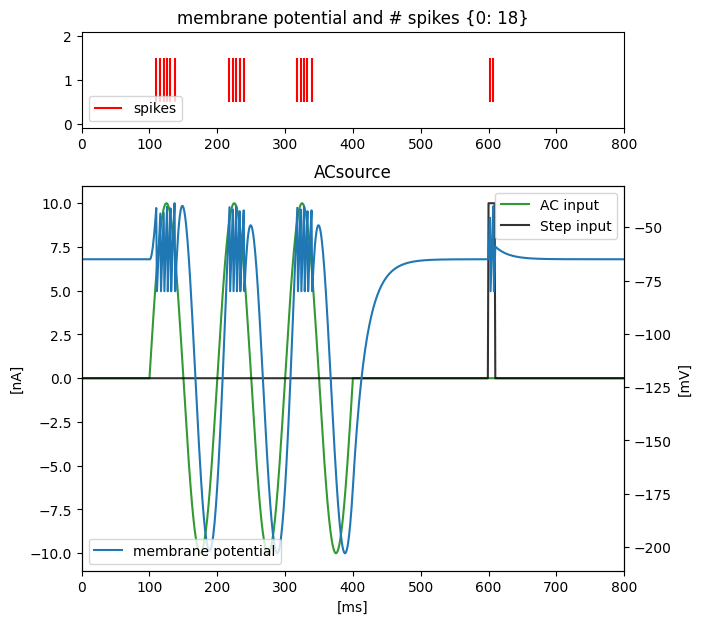

In [12]:
print(f'cell0 spikes: {cell0.get_spike_counts()}')

fig, ax = plt.subplots(1,1, figsize=(7,5))
#fig.tight_layout(pad=5)

ax.plot(i, 'green', alpha=0.8, label='AC input')
ax.plot(stepPulse, 'k', alpha=0.8, label='Step input')

ax1=ax.twinx()
ax1.plot(v0, label='membrane potential')

#ax1.axhline(y=cell0[0].v_thresh, color='k')
ax2=ax1.inset_axes([0,1.15,1,0.25])
ax2.set_xlim(0, simtime)
ax2.eventplot(np.array(list(spikes0)).T, color='r', alpha=1, label='spikes')

ax.set_ylabel('[nA]')
ax.set_title('ACsource')
ax1.set_title(f'membrane potential and # spikes {cell0.get_spike_counts()}')

ax1.set_ylabel('[mV]')

ax.set_xlim(0, simtime) 
ax.set_xlabel('[ms]') 
#ax1.set_yticklabels(' ')

ax1.legend(loc='lower left') 
ax2.legend(loc='lower left') 
ax.legend(loc='upper right') 

fig.savefig(f'{saveName}.jpeg', dpi=70, bbox_inches='tight', facecolor='white')
